In [20]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve,auc
from keras.utils import normalize, to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import joblib

In [2]:
img_directory = 'dataset/'

# List image files
no_tumor_images = os.listdir(img_directory + 'no/')
yes_tumor_images = os.listdir(img_directory + 'yes/')


In [3]:
dataset = []
label = []
new_size = (64, 64)

# Load and preprocess 'no tumor' images for non-CNN models
for image_name in no_tumor_images:
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(img_directory + 'no/' + image_name)
        if image is not None:
            image = Image.fromarray(image, 'RGB')
            image = image.resize(new_size)
            dataset.append(np.array(image).flatten())
            label.append(0)

# Load and preprocess 'yes tumor' images for non-CNN models
for image_name in yes_tumor_images:
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(img_directory + 'yes/' + image_name)
        if image is not None:
            image = Image.fromarray(image, 'RGB')
            image = image.resize(new_size)
            dataset.append(np.array(image).flatten())
            label.append(1)

In [4]:
dataset = np.array(dataset)
label = np.array(label)

# Train-test split for non-CNN models
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)


In [5]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [6]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train_scaled, y_train)
joblib.dump(knn_model, 'brain_tumor_knn_model.pkl')

['brain_tumor_knn_model.pkl']

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(x_train_scaled, y_train)
joblib.dump(rf_model, 'brain_tumor_rf_model.pkl')


['brain_tumor_rf_model.pkl']

In [8]:
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(x_train_scaled, y_train)
joblib.dump(dt_model, 'brain_tumor_dt_model.pkl')


['brain_tumor_dt_model.pkl']

In [9]:
x_train_cnn = normalize(x_train.reshape(-1, 64, 64, 3), axis=1)
x_test_cnn = normalize(x_test.reshape(-1, 64, 64, 3), axis=1)
y_train_cnn = to_categorical(y_train, num_classes=2)
y_test_cnn = to_categorical(y_test, num_classes=2)


In [10]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(32, (3, 3), kernel_initializer="he_uniform"))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), kernel_initializer="he_uniform"))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(2))
cnn_model.add(Activation('sigmoid'))

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(x_train_cnn, y_train_cnn, batch_size=16, verbose=1, epochs=10, validation_data=(x_test_cnn, y_test_cnn), shuffle=False)
cnn_model.save('BrainTumor_CNN.h5')

C:\Users\Vishal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6516 - loss: 0.6014 - val_accuracy: 0.8017 - val_loss: 0.4253
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8259 - loss: 0.3979 - val_accuracy: 0.8483 - val_loss: 0.3364
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8761 - loss: 0.2995 - val_accuracy: 0.9000 - val_loss: 0.2544
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9042 - loss: 0.2400 - val_accuracy: 0.9317 - val_loss: 0.2004
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9403 - loss: 0.1644 - val_accuracy: 0.9633 - val_loss: 0.1424
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9680 - loss: 0.1133 - val_accuracy: 0.9467 - val_loss: 0.1269
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9762 - loss: 0.0797 - val_accuracy: 0.9667 - val_loss: 0.1032
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9818 - loss: 0.0601 - val_accuracy: 0.

In [11]:
history_cnn = cnn_model.fit(x_train_cnn, y_train_cnn, batch_size=16, verbose=1, epochs=10, validation_data=(x_test_cnn, y_test_cnn), shuffle=False)




Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9903 - loss: 0.0337 - val_accuracy: 0.9650 - val_loss: 0.1612
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9953 - loss: 0.0243 - val_accuracy: 0.9383 - val_loss: 0.1947
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9755 - loss: 0.0722 - val_accuracy: 0.9733 - val_loss: 0.1020
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9972 - loss: 0.0118 - val_accuracy: 0.9733 - val_loss: 0.1537
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9951 - loss: 0.0155 - val_accuracy: 0.9750 - val_loss: 0.1055
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9995 - loss: 0.0055 - val_accuracy: 0.9783 - val_loss: 0.0992
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9986 - loss: 0.0065 - val_accuracy: 0.9683 - val_loss: 0.1168
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9936 - loss: 0.0208 - val_accuracy: 0.

In [12]:
y_pred_prob_cnn = cnn_model.predict(x_test_cnn)
y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1)

# Calculate metrics for CNN model
accuracy_cnn = accuracy_score(np.argmax(y_test_cnn, axis=1), y_pred_cnn)
conf_matrix_cnn = confusion_matrix(np.argmax(y_test_cnn, axis=1), y_pred_cnn)
class_report_cnn = classification_report(np.argmax(y_test_cnn, axis=1), y_pred_cnn)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [44]:
def evaluate_non_cnn_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    y_proba = model.predict_proba(x_test)[:, 1]
    
    return accuracy, conf_matrix, class_report,y_proba


In [46]:
models = {
    'Decision Tree': dt_model,
    'KNN': knn_model,
    'Random Forest': rf_model,
}

model_names = list(models.keys())
accuracies = []
conf_matrices = []
class_reports = []
probas = {}
histories = {}

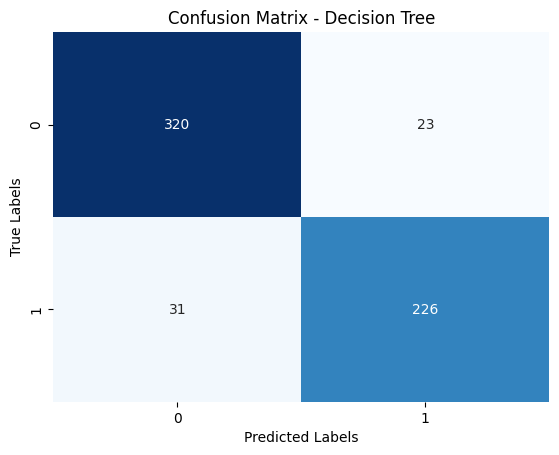

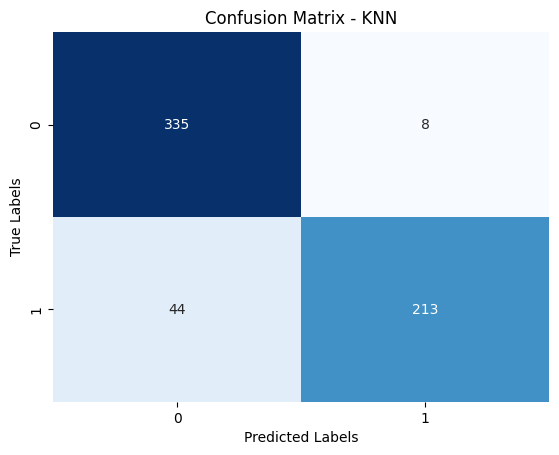

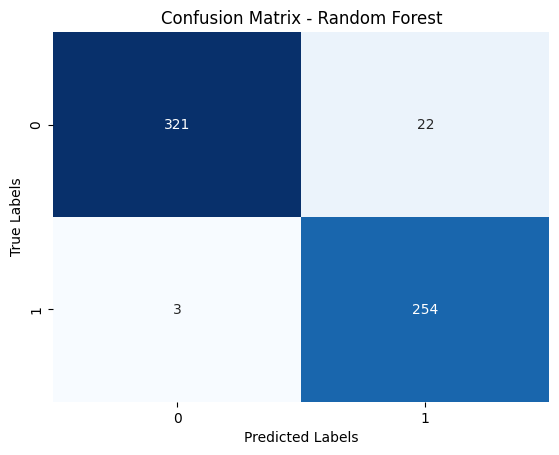

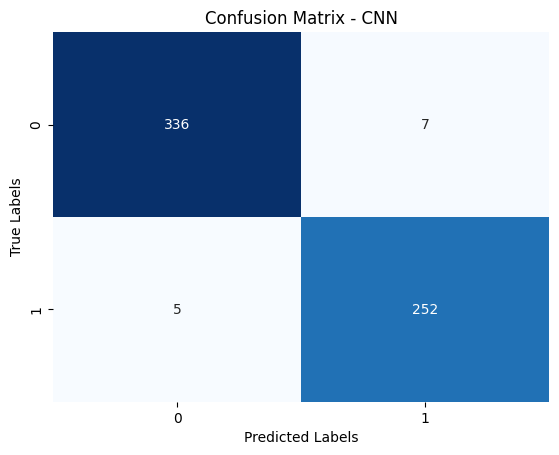

In [48]:
for name, model in models.items():
    accuracy, conf_matrix, class_report, y_proba = evaluate_non_cnn_model(model, x_test_scaled, y_test)
    accuracies.append(accuracy)
    conf_matrices.append(conf_matrix)
    class_reports.append(class_report)
    probas[name]= y_proba

    # Plot confusion matrix for each non-CNN model
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Plot training history for non-CNN models
    history = model.fit(x_train_scaled, y_train)
    histories[name] = history


plt.figure()
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - CNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

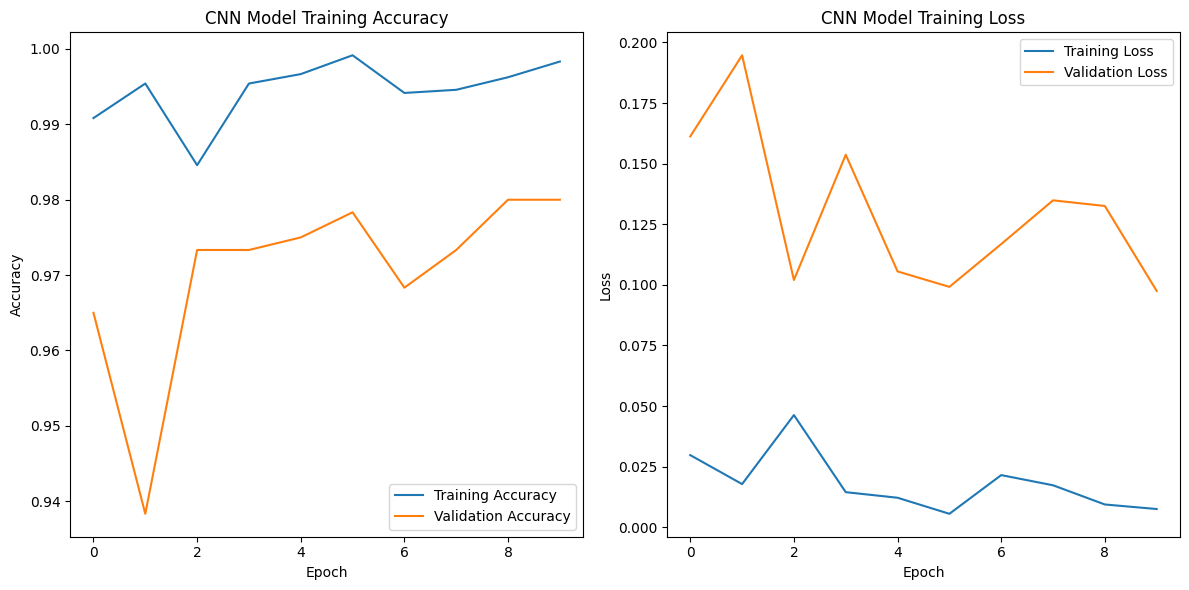

In [49]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
for i, name in enumerate(model_names):
    print(f"{name} Metrics:")
    print(f"Accuracy: {accuracies[i]:.2f}")
    print("Classification Report:")
    print(class_reports[i])
    print()


print("CNN Model Metrics:")
print(f"Accuracy: {accuracy_cnn:.2f}")
print("Classification Report:")
print(class_report_cnn)

Decision Tree Metrics:
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       343
           1       0.91      0.88      0.89       257

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600


KNN Metrics:
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       343
           1       0.96      0.83      0.89       257

    accuracy                           0.91       600
   macro avg       0.92      0.90      0.91       600
weighted avg       0.92      0.91      0.91       600


Random Forest Metrics:
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       343
           1       0.92      0.99      0.95       257

    acc

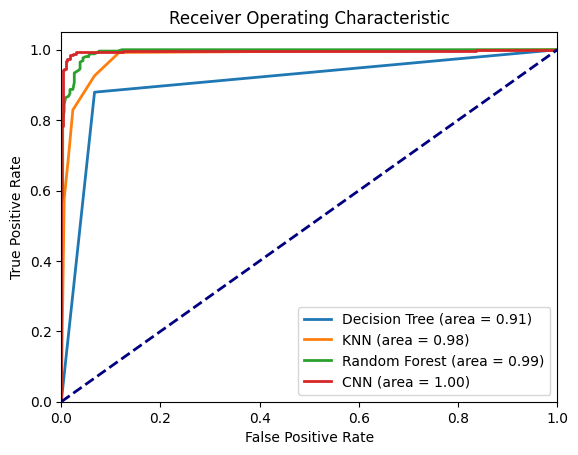

In [51]:
plt.figure()
for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

# Add CNN ROC curve
fpr_cnn, tpr_cnn, _ = roc_curve(np.argmax(y_test_cnn, axis=1), y_pred_prob_cnn[:, 1])
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, lw=2, label=f'CNN (area = {roc_auc_cnn:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()